# 6 single doublepads - V01
This variant has an effective Q for resonators around 200

In [16]:
import skrf as rf
from math import pi
from skrf.media.cpw import CPW
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from modeling.utils.resonators import cpw_cl_ll, resonator_kappa, cpw_kinetic_inductance, penetration_depth
from modeling.utils.network import assemble_network
from modeling.utils.qubits import get_Ic_from_Lj
from qucat import Network,L,J,C,R
from modeling.clockmon.libraries.clockmon_library import clockmon_coupling_libraries, clockmon_library, clockmon_cqr_to_ground
from modeling.smooth_capacitor.libraries.smooth_capacitor_library import digit_tee_library, digit_tee_ck_to_ground, get_ck
from scqubits import Transmon
from modeling.resonance_fit import ResFit
from scipy.optimize import fsolve

In [17]:
smooth_capacitor_lib = digit_tee_library(deembed = [300, 200])
ck_to_ground = digit_tee_ck_to_ground(deembed=[300, 200])
clockmon_lib = clockmon_library(deembed = 200) 
cqr_to_ground = clockmon_cqr_to_ground(deembed = 200)

In [18]:
planck_h = 6.62607015e-34
e_charge = 1.60217663e-19
phi0 =  2.067833848e-15 # Wb

a = 10e-6
b = 6e-6
ep_r = 11.45

nb_qubits = 6
rr_freq_target = np.array([7.0e9, 7.15e9, 7.6e9, 7.45e9, 7.3e9, 7.70e9])
qubit_freq_target = np.array([5e9, 5.15e9, 5.6e9, 5.45e9, 5.3e9, 5.7e9])
c_sigma = 90.47e-15
kappa_target = 2e6 # This is the target kappa for the resonators BEFORE applying the Purcell filter. If the Purcell filter is applied, the effective kappa will be higher and can be determined through resonance fitting.
target_parameters = {
    "chi": 5.6e6,
    "qubit_frequency": qubit_freq_target,
    "rr_frequencies_target": rr_freq_target,
    "c_sigma_unloaded": c_sigma
}
Z0 = CPW(w = a, s = b, ep_r = ep_r).z0[0].real
l_r = Z0*pi/(4*pi*rr_freq_target)
c_r = 1/((2*pi*rr_freq_target)**2*l_r)

In [19]:
def minimize_func(x, c_r = None, l_r = None, target_qubit_frequency = None):
    cir = Network([
        C(0,1,c_sigma - x[0]*1e-15), # transmon
        J(0,1,'Lj'),
        C(0,2,c_r - x[0]*1e-15), # resonator
        L(0,2,l_r),
        C(1,2, x[0]*1e-15), # coupling capacitor
    ])
    err_chi = abs(cir.kerr(Lj = x[1]*1e-9)[0,1] - target_parameters["chi"])*1e3
    
    H = cir.hamiltonian(modes = [0, 1],
                        taylor = 6,
                        excitations = [10, 10],
                        Lj = x[1]*1e-9)
    ee = H.eigenenergies().real
    ee -= ee[0]
    err_freq = abs(ee[1] - target_qubit_frequency)
    return err_chi, err_freq

In [20]:
cqrs = np.zeros((nb_qubits))
Ljs = np.zeros((nb_qubits))
for i in range(nb_qubits):
    cqr, lj = fsolve(minimize_func, [10, 10], args =(c_r[i], l_r[i], qubit_freq_target[i]))
    cqrs[i] = cqr*1e-15
    Ljs[i] = lj*1e-9

print(cqrs)
print(Ljs)

[9.53755106e-15 9.23657084e-15 8.42280554e-15 8.68026198e-15
 8.95117929e-15 8.25818771e-15]
[1.02239854e-08 9.66250319e-09 8.22981039e-09 8.66979386e-09
 9.14599723e-09 7.95482494e-09]


In [21]:
Ic = get_Ic_from_Lj(Ljs)
EC = e_charge**2/(c_sigma)/2/planck_h
Ej = Ic*phi0/2/pi/planck_h

anharmonicities = np.zeros(6)
for i in range(6):
    transmon = Transmon(EJ = Ej[i], EC=EC, ng = 0, ncut = 31)
    anharmonicities[i] = transmon.anharmonicity()

Energy dispersion is  1.7003300094604493e-07 GHz


Spectral data:   0%|          | 0/101 [00:00<?, ?it/s]

(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='$n_g$', ylabel='energy [GHz]'>)

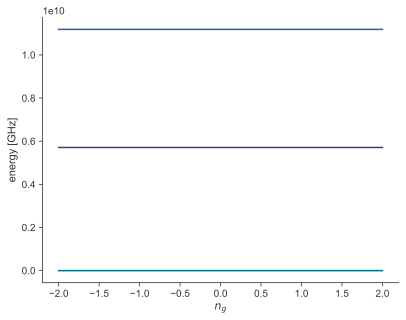

In [22]:
ng_list = np.linspace(-2, 2, 101)
e01_list = []
for ng in ng_list:
    e01_list.append(Transmon(EJ=Ej[0], EC=EC, ng=ng, ncut=31).E01())
e01_min = min(e01_list)
e01_max = max(e01_list)
delta_e01 = (e01_max - e01_min)/1e9
print("Energy dispersion is ", delta_e01, "GHz")
transmon.plot_evals_vs_paramvals('ng', ng_list, evals_count=3, subtract_ground=True)

In [23]:
corrected_rr_freq = np.zeros((nb_qubits))
for i in range(nb_qubits):
    cir = Network([
        C(0,1,c_sigma- cqrs[i]), # transmon
        J(0,1,'Lj'),
        C(0,2,c_r[i] - cqrs[i]), # resonator
        L(0,2,l_r[i]),
        C(1,2, cqrs[i]), # coupling capacitor
        R(0, 2, 1e6)
        ])
    # f,k,A,chi = 
    cir.f_k_A_chi(pretty_print=True, Lj = Ljs[i])
    ham = cir.hamiltonian(modes = [0, 1],
                        taylor = 6,
                        excitations = [10, 10],
                        Lj = Ljs[i])
    ee = ham.eigenenergies()
    ee -= ee[0]
    corrected_rr_freq[i] = ee[2]


         mode |       freq.  |       diss.  |       anha.  |
            0 |     5.22 GHz |     3.07 kHz |      209 MHz |
            1 |     7.03 GHz |      559 kHz |     37.5 kHz |

Kerr coefficients (diagonal = Kerr, off-diagonal = cross-Kerr)
         mode |         0    |         1    |
            0 |      209 MHz |              |
            1 |      5.6 MHz |     37.5 kHz |

         mode |       freq.  |       diss.  |       anha.  |
            0 |     5.37 GHz |      3.2 kHz |      209 MHz |
            1 |     7.18 GHz |      570 kHz |     37.5 kHz |

Kerr coefficients (diagonal = Kerr, off-diagonal = cross-Kerr)
         mode |         0    |         1    |
            0 |      209 MHz |              |
            1 |      5.6 MHz |     37.5 kHz |

         mode |       freq.  |       diss.  |       anha.  |
            0 |     5.82 GHz |     3.61 kHz |      209 MHz |
            1 |     7.63 GHz |      606 kHz |     37.5 kHz |

Kerr coefficients (diagonal = Kerr, off-diag

 C:\Users\pc\AppData\Local\Temp\ipykernel_23112\664116265.py: 19

         mode |       freq.  |       diss.  |       anha.  |
            0 |     5.67 GHz |     3.47 kHz |      209 MHz |
            1 |     7.48 GHz |      594 kHz |     37.5 kHz |

Kerr coefficients (diagonal = Kerr, off-diagonal = cross-Kerr)
         mode |         0    |         1    |
            0 |      209 MHz |              |
            1 |      5.6 MHz |     37.5 kHz |

         mode |       freq.  |       diss.  |       anha.  |
            0 |     5.52 GHz |     3.34 kHz |      209 MHz |
            1 |     7.33 GHz |      582 kHz |     37.5 kHz |

Kerr coefficients (diagonal = Kerr, off-diagonal = cross-Kerr)
         mode |         0    |         1    |
            0 |      209 MHz |              |
            1 |      5.6 MHz |     37.5 kHz |

         mode |       freq.  |       diss.  |       anha.  |
            0 |     5.92 GHz |      3.7 kHz |      209 MHz |
            1 |     7.73 GHz |      614 kHz |     37.5 kHz |

Kerr coefficients (diagonal = Kerr, off-diag

In [24]:
cir = Network([
    C(0,1,c_sigma- cqrs[i]), # transmon
    J(0,1,'Lj'),
    C(0,2,c_r[i] - cqrs[i]), # resonator
    L(0,2,l_r[i]),
    C(1,2, cqrs[i]), # coupling capacitor
    ])

In [25]:
g = 2*np.pi*EC/ (e_charge) * (Ej/EC/2)**(1/4) * cqrs / (c_r) * np.sqrt(2*planck_h * rr_freq_target * (c_r))
delta = (rr_freq_target - transmon.E01()) * 2*np.pi

lamb_shift = 2*g**2 / delta / 2 / np.pi
g/2/np.pi

array([1.79949159e+08, 1.80536224e+08, 1.82155744e+08, 1.81638068e+08,
       1.81098691e+08, 1.82489457e+08])

In [29]:
cqrs

array([9.53755106e-15, 9.23657084e-15, 8.42280554e-15, 8.68026198e-15,
       8.95117929e-15, 8.25818771e-15])

In [27]:
def minimize_for_ck(x, resonator_frequency):
    k = resonator_kappa(resonator_frequency, x[0]*1e-15, Z0)/ 2/ pi / np.sqrt(2)
    return abs(k - kappa_target)

cks = np.zeros((nb_qubits))
for i in range(nb_qubits):
    cks[i] = abs(fsolve(minimize_for_ck, 5, args = (rr_freq_target[i]))[0]*1e-15)

In [28]:
cqr_to_ground(cqrs)

ValueError: A value (9.537551055462395e-15) in x_new is above the interpolation range's maximum value (7.349721278031156e-15).

In [94]:
# Readout resonators (lambda/4)
rr_cap_to_ground = cqr_to_ground(cqrs)
digit_cap_inductance = 1.6210000000000005e-11 # Simulate this
tee_cap_inductance = 3.1509999999999996e-11 # Simulate this
c_l, l_l = cpw_cl_ll(a, b, ep_r)
v_ph = 1/np.sqrt(c_l*l_l)
unloaded_wg_lengths = v_ph / rr_freq_target / 4
l_r_loaded = 1/2 * Z0 * np.sqrt((unloaded_wg_lengths*c_l)*
                                (unloaded_wg_lengths*l_l - digit_cap_inductance - tee_cap_inductance))
c_r_loaded = 2/(np.pi**2 * Z0)*np.sqrt((unloaded_wg_lengths*c_l - rr_cap_to_ground - ck_to_ground(cks))*
                                (unloaded_wg_lengths*l_l))
c_r_loaded -= cqrs
c_r_loaded -= cks
resonator_waveguide_lengths = np.array(np.pi * np.sqrt((c_r_loaded * l_r_loaded) / (c_l*l_l)))
print(f"Waveguide lengths: {resonator_waveguide_lengths*1e6} um")

Waveguide lengths: [4074.62259501 3990.40108217 3757.30669114 3831.9428251  3909.57586003
 3709.12948571] um


In [95]:
coupler_width_given_c_qr, c_sigma_given_coupler_width = clockmon_coupling_libraries()
ck_given_coupling = get_ck()
for i in range(nb_qubits):
    coupler_width = coupler_width_given_c_qr(cqrs[i])
    finger_control = ck_given_coupling(cks[i])
    print(f"Coupler width for qubit {i}: {coupler_width:.5} um")
    print(f"Finger control for qubit {i}: {finger_control:.5}")
    print(f"Resonator length for qubit {i}: {resonator_waveguide_lengths[i]*1e6:.5} um")

Coupler width for qubit 0: 134.7 um
Finger control for qubit 0: 1.7994
Resonator length for qubit 0: 4074.6 um
Coupler width for qubit 1: 128.92 um
Finger control for qubit 1: 1.7762
Resonator length for qubit 1: 3990.4 um
Coupler width for qubit 2: 113.33 um
Finger control for qubit 2: 1.7127
Resonator length for qubit 2: 3757.3 um
Coupler width for qubit 3: 118.27 um
Finger control for qubit 3: 1.733
Resonator length for qubit 3: 3831.9 um
Coupler width for qubit 4: 123.46 um
Finger control for qubit 4: 1.7541
Resonator length for qubit 4: 3909.6 um
Coupler width for qubit 5: 110.18 um
Finger control for qubit 5: 1.6995
Resonator length for qubit 5: 3709.1 um


# scikit-rf network

In [96]:
fl_traits = pd.read_csv("single_doublepads_00.csv").values[0][1:]
tee_size = pd.read_csv("single_doublepads_00.csv").values[1][1:]
res_length = pd.read_csv("single_doublepads_00.csv").values[2][1:]

tee_size = tee_size[pd.isna(tee_size) == 0]
res_length =res_length[pd.isna(res_length) == 0]

transmission_line_tee_points = [
    float(fl_traits[0]), # From input launcher to feedline capacitor
    fl_traits[1] + (a + 2*b)/2, # From feedline capacitor to tee0
    fl_traits[2] + (a + 2*b), # From tee0 to tee1
    fl_traits[3] + (a + 2*b), # From tee1 to tee2
    fl_traits[4] + (a + 2*b), # From tee2 to tee3
    fl_traits[5] + (a + 2*b), # From tee3, to tee4 
    fl_traits[6] + (a + 2*b), # From tee4, to tee5
    fl_traits[7] + (a + 2*b), # From tee5, to tee6 (from tee6 we split into output launcher and feedline resonator tail)
    fl_traits[8] + (a + 2*b)/2, # From tee6 to output launcher
    fl_traits[9] + 30, # from tee6 to ground (feedline resonator tail endpoint)
]

feedline_res_length = fl_traits[1] + (a + 2*b)/2 + \
    fl_traits[2] + (a + 2*b) + \
    fl_traits[3] + (a + 2*b) + \
    fl_traits[4] + (a + 2*b) + \
    fl_traits[5] + (a + 2*b) + \
    fl_traits[6] + (a + 2*b) + \
    fl_traits[7] + (a + 2*b) + \
    fl_traits[8] + 30 + fl_traits[9] + (a + 2*b)/2
qb_pos_0 = fl_traits[1] + (a + 2*b)/2
qb_pos_1 = qb_pos_0 + fl_traits[2] + (a + 2*b)
qb_pos_2 = qb_pos_1 + fl_traits[3] + (a + 2*b)
qb_pos_3 = qb_pos_2 + fl_traits[4] + (a + 2*b)
qb_pos_4 = qb_pos_3 + fl_traits[5] + (a + 2*b)
qb_pos_5 = qb_pos_4 + fl_traits[6] + (a + 2*b)

In [97]:
def resonance_profile(x, total_length, order):
    return abs(np.cos(2*np.pi*x*(order + 1/2)/total_length/2))

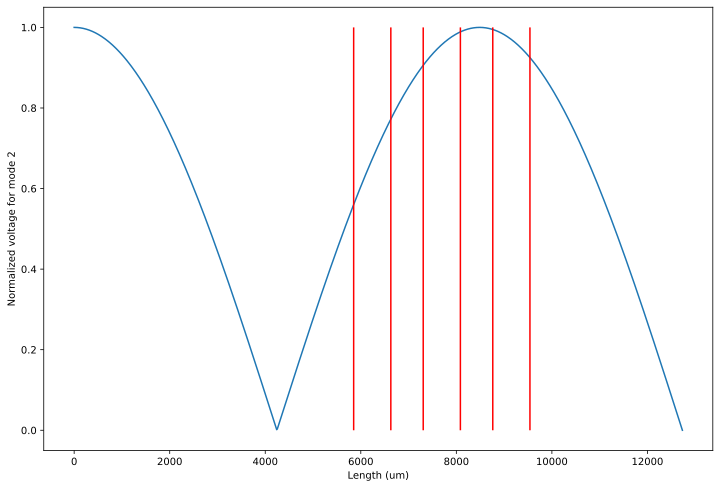

In [98]:
xdata = np.linspace(0, feedline_res_length, 1001)
plt.figure(figsize=(12, 8))
plt.ylabel("Normalized voltage for mode 2")
plt.xlabel("Length (um)")

plt.plot(xdata, resonance_profile(xdata, feedline_res_length, order = 1))
plt.vlines([qb_pos_0, qb_pos_1, qb_pos_2, qb_pos_3, qb_pos_4, qb_pos_5], ymin = 0, ymax = 1, colors="r")
corrections_to_ck = resonance_profile(np.array([qb_pos_0, qb_pos_1, qb_pos_2, qb_pos_3, qb_pos_4, qb_pos_5]), feedline_res_length, order = 1)

In [99]:
def minimize_for_ck(x, resonator_frequency, correction_to_ck):
    k = resonator_kappa(resonator_frequency, x[0]*1e-15, Z0)/ 2/ pi #/ np.sqrt(2)
    k = k*correction_to_ck
    return abs(k - kappa_target)

cks = np.zeros((nb_qubits))
for i in range(nb_qubits):
    cks[i] = fsolve(minimize_for_ck, 5, args = (rr_freq_target[i], corrections_to_ck[i]))[0]*1e-15
cks = np.abs(cks)

In [114]:
resonator_capacitance = c_r - cks -  cqrs
cfl = 5e-14
options = {
    "qubit_c": np.array([c_sigma]*6),
    "qubit_l": Ljs,
    "readout_resonator_c": resonator_capacitance,
    "readout_resonator_l": l_r,
    "ck": cks,
    "cqr": cqrs,
    "feedline_traits": transmission_line_tee_points,
    "cfl": cfl,
    "frequency": [7, 7.01],
    "n_points": 2001,
    "type": "feedline_resonator",
    "a": a,
    "b": b,
    "ep_r": ep_r
}

2-Port Network: '',  6.9-7.8 GHz, 10001 pts, z0=[50.+0.j 50.+0.j]


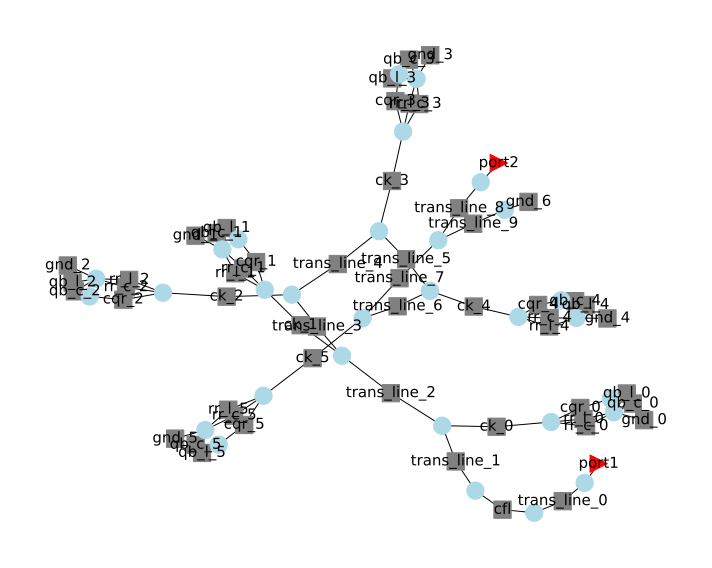

In [115]:
cnx = assemble_network(options)
cir = rf.Circuit(cnx)

cir.plot_graph(network_labels=True, network_fontsize=15,
               port_labels=True, port_fontsize=15,
               edge_fontsize=10)

# Get the resulting Network from the 'network' parameter:
ntw = cir.network
print(ntw)

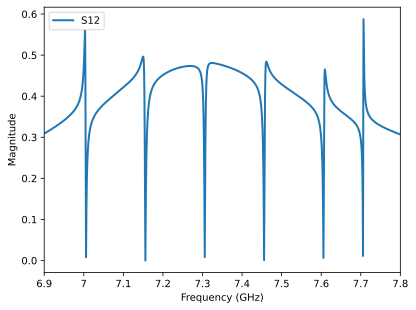

In [116]:
ntw.plot_s_mag(m=0, n=1, lw=2)

In [117]:
# We can make basic guesses by zooming the ntw.s plot
kappa_guess = 2.5e6 # FHWM
freq = 7.76e9
Q = freq / kappa_guess / np.sqrt(2)
Q

2194.8594488030435

In [104]:
# From lower to higher freq (FWHM || fit)
# 1769 || 1670
# 1580 || 1469
# 1700 || 1466
# 1880 || 1649
# 1790 || 1915
# 1829 || 2110

Resonant frequency: 7005660000.321215 Hz
Q total: 2022.8739341593564
Q internal: set to inf
Complex phase: 6.469117556164761


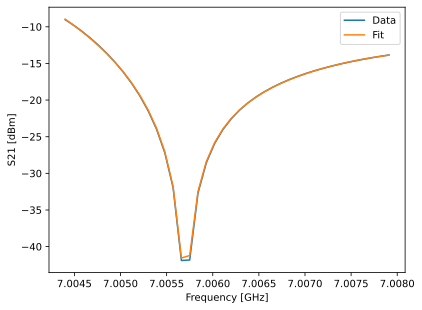

In [ ]:
# We can attempt to find the resonator Q by fitting the resonance
initial_params = [1, 1e4, 6, 2, 0, 0, 0]
fitter = ResFit(ntw, 110, 1200, ideal = True)
fitter.fit_resonance(initial_params=initial_params)
fitter.plot_resonance()

### Purcell filter Quality estimation
We cannot extract Q based on simple formulas because the feedline is split closer to the launchpad (tail length modifies significantly the S21). <br>
We can roughly estimate it by visually inspecting the linewidth, or fitting.

In [133]:
options_only_purcell = {
    "qubit_c": np.array([c_sigma]*6),
    "qubit_l": Ljs,
    "readout_resonator_c": resonator_capacitance,
    "readout_resonator_l": l_r,
    "ck": np.array([0,0,0,0,0,0]), # We remove the resonataors
    "cqr": cqrs,
    "feedline_traits": transmission_line_tee_points,
    "cfl": cfl,
    "frequency": [5, 9],
    "n_points": 2001,
    "type": "feedline_resonator",
    "a": a,
    "b": b,
    "ep_r": ep_r
}
cnx_only_purcell = assemble_network(options_only_purcell)
cir_only_purcell = rf.Circuit(cnx_only_purcell)
# Get the resulting Network from the 'network' parameter:
ntw_only_purcell = cir_only_purcell.network
print(ntw_only_purcell)

2-Port Network: '',  5.0-9.0 GHz, 2001 pts, z0=[50.+0.j 50.+0.j]


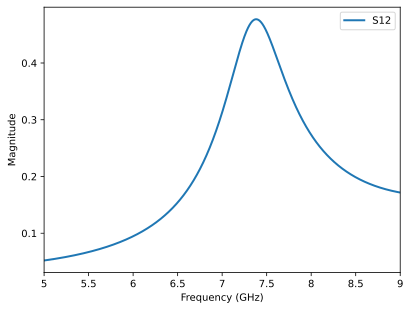

In [134]:
ntw_only_purcell.plot_s_mag(m=0, n=1, lw=2)

Resonant frequency: 7382000000.996784 Hz
Q total: 10.283674457018813
Q internal: 11.67658545956559
Complex phase: 0.20193529427278806


 C:\Users\pc\Desktop\work\QDAST\src\modeling\resonance_fit.py: 46

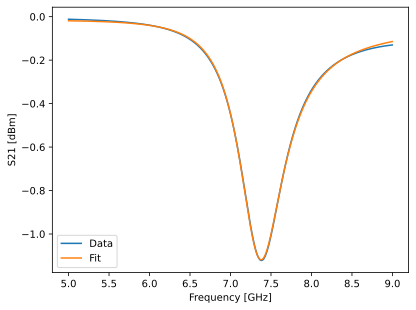

In [135]:
initial_params = [1, 20, 1e2, 1, 1, 0, 0, 0]
fitter = ResFit(ntw_only_purcell, 0, 2000, ideal = False, fit_type = "S11", poly_noise = False)
fitter.fit_resonance(initial_params=initial_params)
fitter.plot_resonance()

In [33]:
(1/10.28 + 1/11)**(-1)

5.31390977443609

In [32]:
7.382e9 / 1.3e9

5.678461538461539

In [136]:
# T1 Purcell:
delta = rr_freq_target - target_parameters["qubit_frequency"]
k_purcell = kappa_target* (g/2/np.pi/delta)**2
T1_purcell_pre_filter = 1/(2*np.pi*k_purcell)
print(T1_purcell_pre_filter)

[0.0001732  0.00017209 0.0001691  0.00017005 0.00017104 0.00016849]


In [137]:
# T1 Purcell - adapting the formula to the filter presence (eq. 178 of https://doi.org/10.1063/1.5089550):

purcell_Q = fitter.popt[1] #7.5e9/ 500e6#(resonator_kappa(7.5e9, cfl, Z0) / 2/pi) # corresponding to a kappa FWHM of 500 MHz
delta = rr_freq_target - target_parameters["qubit_frequency"]
actual_kappa_readout_resonator = resonator_kappa(rr_freq_target, cks, Z0)/ 2/ pi# / np.sqrt(2)
k_purcell_ = actual_kappa_readout_resonator* (g/2/np.pi/delta)**2

k_purcell_ = kappa_target* (g/2/np.pi/delta)**2
T1_purcell = 1/(2*np.pi*k_purcell_) / (qubit_freq_target/ 2 / purcell_Q / delta)
print(T1_purcell)

[0.00142488 0.00137455 0.00124209 0.00128344 0.00132751 0.00121591]


In [138]:
# For when we'll need chargelines/fluxlines: https://quantumcomputing.stackexchange.com/questions/33136/how-to-estimate-the-losses-of-a-transmon-qubit-to-its-flux-bias-line

In [139]:
finger_control_feedline = ck_given_coupling(cfl)
print(f"Finger control probeline capacitor: {finger_control_feedline:.5}")

Finger control probeline capacitor: 4.2527


In [ ]:
df = pd.DataFrame(index=['qb0','qb1','qb2', 'qb3', 'qb4', 'qb5'])
df['resonator 01 [GHz]'] = rr_freq_target / 1e9
df['qubit 01 [GHz]'] = qubit_freq_target / 1e9
df['anharmonicity [MHz]'] = np.floor(anharmonicities / 1e6)
df['chi/2pi [MHz]'] = np.array([target_parameters["chi"]]*6)/1e6
df['g/2pi [MHz]'] = g/2/np.pi * 1e-6
df['C_sigma [fF]'] = np.array([c_sigma]*6) * 1e15
df["Lj [nH]"] = Ljs * 1e9
df['Ic [nA]'] = Ic * 1e9
df['T1 Purcell [us]'] = np.floor(T1_purcell * 1e6)
df['T1 Purcell if no filter [us]'] = np.floor(T1_purcell_pre_filter * 1e6)
df['Resonator Q'] = np.array([1670, 1469, 1466, 1649, 1915, 2110])
df

,resonator 01 [GHz],qubit 01 [GHz],anharmonicity [MHz],chi/2pi [MHz],g/2pi [MHz],C_sigma [fF],Lj [nH],Ic [nA],T1 Purcell [us],T1 Purcell if no filter [us],Resonator Q
qb0,7.00,5.00,-239.0,1.3,85.740434,90.47,10.252561,32.099881,1424.0,173.0,1670
qb1,7.15,5.15,-238.0,1.3,86.015183,90.47,9.689274,33.966010,1374.0,172.0,1469
qb2,7.60,5.60,-236.0,1.3,86.773877,90.47,8.252007,39.881933,1242.0,169.0,1466
qb3,7.45,5.45,-237.0,1.3,86.531239,90.47,8.693390,37.857038,1283.0,170.0,1649
qb4,7.30,5.30,-237.0,1.3,86.278554,90.47,9.171113,35.885063,1327.0,171.0,1915
qb5,7.70,5.70,-236.0,1.3,86.930344,90.47,7.976149,41.261262,1215.0,168.0,2110
